In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#
root_dir = '/kaggle/input/aptos2019-blindness-detection'
train_img_dir = os.path.join(root_dir, 'train_images')
test_img_dir = os.path.join(root_dir, 'test_images')
#
# Load the train and test CSV files
train_df = pd.read_csv(os.path.join(root_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(root_dir, 'test.csv'))
train_df['file_path'] = train_df['id_code'].apply(lambda x: os.path.join(train_img_dir, f"{x}.png"))
test_df['file_path'] = test_df['id_code'].apply(lambda x: os.path.join(test_img_dir, f"{x}.png"))
# Convert the 'diagnosis' column to string to avoid TypeError with␣ImageDataGenerator
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
# Verify that all paths in 'file_path' exist
missing_train_files = train_df[~train_df['file_path'].apply(os.path.exists)]
if len(missing_train_files) > 0:
    print(f"Missing training files: {len(missing_train_files)}")
# Data augmentation and ImageDataGenerator setup
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # Use 20% for validation
)
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training' # 80% of data used for training
)
# Validation data generator
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation' # 20% of data used for validation
)
# Test data generator (no labels)
test_datagen = ImageDataGenerator(
preprocessing_function=tf.keras.applications.resnet.preprocess_input
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)
# Print summary of each generator for confirmation
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.
Training samples: 2930
Validation samples: 732
Test samples: 1928


In [10]:
# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.regularizers import l2
# # Load the EfficientNetB0 model without the top layer and specify a smaller␣input shape
# base_model = EfficientNetB0(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
# base_model.trainable = True
# for layer in base_model.layers[:-20]:
#     layer.trainable = False
    
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)  # Add Batch Normalization
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Dense layer with L2 regularization
# x = Dropout(0.5)(x)  # Dropout for regularization
# output = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Output layer

# model = Model(inputs=base_model.input, outputs=output)
# model.compile(
#     optimizer=Adam(learning_rate=1e-4),  # Adjust the learning rate as necessary
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )
# x = base_model.output
# # Print model summary
# model.summary()
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Unfreeze the last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=7,  # Adjust as needed
#     steps_per_epoch=len(train_generator),
#     validation_steps=len(val_generator)
# )

# import matplotlib.pyplot as plt

# # Plot learning curves
# def plot_learning_curves(history):
#     # Extract metrics from the history object
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']

#     # Create subplots for loss and accuracy
#     plt.figure(figsize=(12, 5))

#     # Accuracy subplot
#     plt.subplot(1, 2, 1)
#     plt.plot(acc, label='Training Accuracy', marker='o')
#     plt.plot(val_acc, label='Validation Accuracy', marker='o')
#     plt.title('Model Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='lower right')
#     plt.grid()

#     # Loss subplot
#     plt.subplot(1, 2, 2)
#     plt.plot(loss, label='Training Loss', marker='o')
#     plt.plot(val_loss, label='Validation Loss', marker='o')
#     plt.title('Model Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend(loc='upper right')
#     plt.grid()

#     plt.tight_layout()
#     plt.show()

# # Call this function after training your model
# plot_learning_curves(history)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Global pooling layer to reduce dimensions
x = layers.BatchNormalization()(x)  # Batch normalization
x = layers.Dropout(0.3)(x)  # Dropout regularization
x = layers.Dense(512, activation='relu')(x)  # Dense layer
x = layers.BatchNormalization()(x)  # Batch normalization
x = layers.Dropout(0.3)(x)  # Dropout regularization
output = layers.Dense(5, activation='softmax')(x)  # Output layer for 5 categories (APTOS classification)

# Final model
model = models.Model(inputs=base_model.input, outputs=output)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,715,176 (17.99 MB)

 Trainable params: 2,012,981 (7.68 MB)

 Non-trainable params: 2,702,195 (10.31 MB)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=6,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/6


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731836986.115803     185 service.cc:145] XLA service 0x7ae2a40030a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731836986.115857     185 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731836986.115861     185 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/92 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.1797 - loss: 2.5850    

I0000 00:00:1731837014.126275     185 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 573s 5s/step - accuracy: 0.4583 - loss: 1.6486 - val_accuracy: 0.7281 - val_loss: 0.8980
Epoch 2/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.6607 - loss: 1.0087 - val_accuracy: 0.7514 - val_loss: 0.7124
Epoch 3/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 421s 4s/step - accuracy: 0.7053 - loss: 0.8868 - val_accuracy: 0.7637 - val_loss: 0.6574
Epoch 4/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - accuracy: 0.7388 - loss: 0.7804 - val_accuracy: 0.7855 - val_loss: 0.6134
Epoch 5/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 424s 4s/step - accuracy: 0.7385 - loss: 0.7601 - val_accuracy: 0.7773 - val_loss: 0.6086
Epoch 6/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - accuracy: 0.7247 - loss: 0.7804 - val_accuracy: 0.7732 - val_loss: 0.6006


In [14]:
# Evaluate model performance
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.7633 - loss: 0.6776
Validation Loss: 0.6092
Validation Accuracy: 0.7855


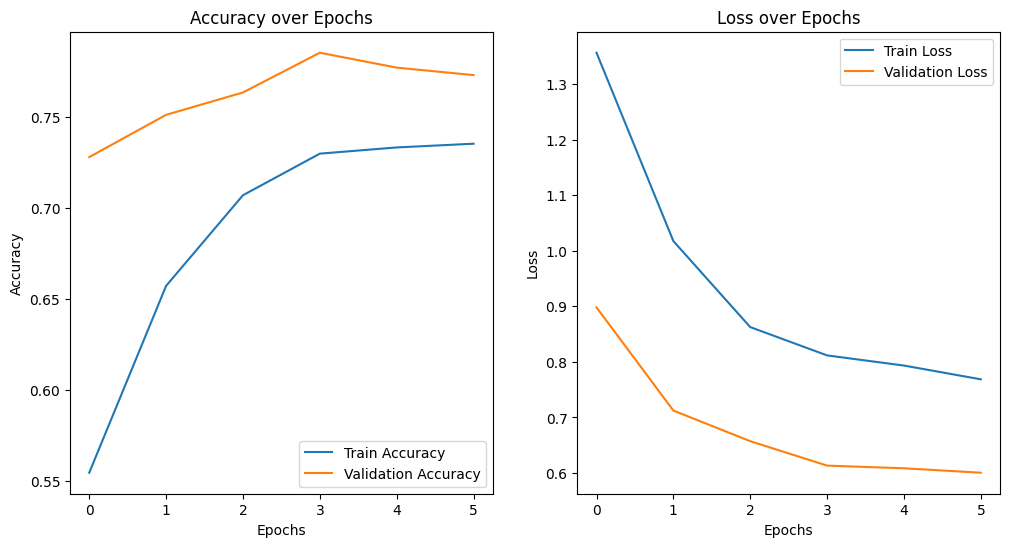

In [15]:
# Plot learning curves
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_learning_curves(history)

Autoencoder

Auto encoder

In [16]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
# root_dir = '/kaggle/input/aptos2019-blindness-detection'
# train_df = pd.read_csv(os.path.join(root_dir, 'train.csv'))
train_datagen = ImageDataGenerator(
preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # Use 20% for validation
)
## Autoencoder
# Training data generator
train_generator_ae = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    subset='training' # 80% of data used for training
)
# Validation data generator
val_generator_ae = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    subset='validation' # 20% of data used for validation
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training' # 80% of data used for training
)
# Validation data generator
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation' # 20% of data used for validation
)

Found 2930 validated image filenames.
Found 732 validated image filenames.
Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Define the autoencoder model
input_img = Input(shape=(224, 224, 3))  # Input shape matches your data

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  # Latent representation

# Decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input

# Build and compile the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')  # MSE loss for reconstruction
autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,459 (5.08 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the autoencoder
history_ae = autoencoder.fit(
    train_generator_ae,
    validation_data=val_generator_ae,
    epochs=5,  # Adjust epochs as needed
    steps_per_epoch=100,
    validation_steps=20
)

# Plot the autoencoder learning curves
#plot_learning_curves(history_ae)  # Use the plot function defined earlier


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 419s 4s/step - loss: 6413.0049 - val_loss: 6262.9204
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - loss: 6398.0718 - val_loss: 6416.0347
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - loss: 6467.8228 - val_loss: 6352.7490
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - loss: 6336.1987 - val_loss: 6550.1753
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - loss: 6414.5635 - val_loss: 6290.3193


Train Generator AE Length: 92
Validation Generator AE Length: 23


In [ ]:
# Extract the encoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('max_pooling2d_2').output)
encoder.summary()

# Build classification model using the encoder
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

x = encoder.output
x = layers.Flatten()(x)

x = layers.Dense(512, activation='tanh')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='elu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(5, activation='softmax')(x)


classification_model = models.Model(encoder.input, output)
classification_model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
classification_model.summary()
history_cls = classification_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Adjust epochs as needed
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370,816 (1.41 MB)

 Trainable params: 370,816 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437,893 (1.67 MB)

 Trainable params: 437,893 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history_cls = classification_model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator
    )

Epoch 1/15


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
plot_learning_curves(history_cls)